<a href="https://colab.research.google.com/github/dimitrod/ehu_atai_strawberry/blob/main/Double_Q_learning_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Deep Q Network Lab**
In this lab we are going to implement Deep Q-Network Algorithm

# **Initialization**

## Install dependencies

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get update
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium[classic_control]
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,620 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,224 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 P

## Import Dependencies

In [ ]:
import os
from typing import Dict, List, Tuple
import math, random

import gym
import gymnasium as gymnasium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import base64
import glob
import io
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from IPython.display import HTML, display, clear_output



#**Implementation**

## **Show recorded video**
The following functions are used in order to show in a video the obtained results

In [ ]:
def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

def remove_videos (video_folder: str):
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for video in list_of_files:
      try:
          os.remove(video)
      except:
          print("Error while deleting file : ", video)

def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

def show_all_videos(video_folder: str) -> str:
    """Show all the videos recorded."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    for video in list_of_files:
      ipython_show_video(video)
    print("Played:", video)


## Autograd Variable

In [ ]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

## Replay Buffer

In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

*###* Testing Replay Buffer

In [ ]:
# We build a Replay buffer for 5 elements
rB = ReplayBuffer(5)

# We are going to add 8 elements
for i in range(8):
  rB.push(i,i,i,i,i)
print("We add 8 elements but there are only ", len(rB), "\nrB: ", rB.buffer)

# We are going to add another value
rB.push(10,10,10,10,10)
print("\nAfter we add a new element the buffer is: ", rB.buffer)

# No we are going to see are sampled some experiences
mini_batch = rB.sample(2)
print("\n The sampled elemenst: ", mini_batch )

mini_batch = rB.sample(3)
print("\n The sampled elemenst: ", mini_batch )


We add 8 elements but there are only  5 
rB:  deque([(array([3]), 3, 3, array([3]), 3), (array([4]), 4, 4, array([4]), 4), (array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7)], maxlen=5)

After we add a new element the buffer is:  deque([(array([4]), 4, 4, array([4]), 4), (array([5]), 5, 5, array([5]), 5), (array([6]), 6, 6, array([6]), 6), (array([7]), 7, 7, array([7]), 7), (array([10]), 10, 10, array([10]), 10)], maxlen=5)

 The sampled elemenst:  (array([10,  5]), (10, 5), (10, 5), array([10,  5]), (10, 5))

 The sampled elemenst:  (array([ 5,  6, 10]), (5, 6, 10), (5, 6, 10), array([ 5,  6, 10]), (5, 6, 10))


## Cart Pole Environment

In [ ]:
env_id = "CartPole-v0"
env = gymnasium.make(env_id, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [ ]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

## Epsilon greedy exploration
Epsilon value is dynamic. It starts with 1.0 value (exploration) and little by little it is going to decay until 0.01 (exploitation)

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

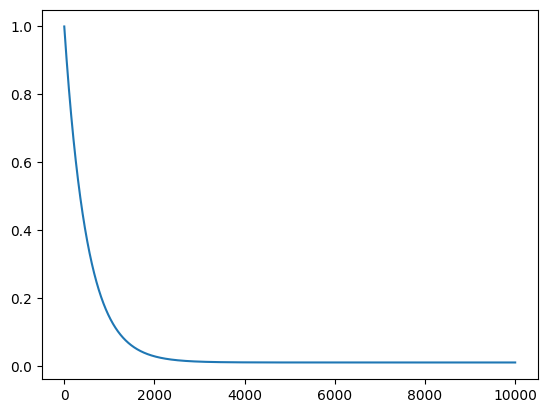

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

        self.optimizer = optim.Adam(self.parameters())
        self.replay_buffer = ReplayBuffer(1000)
        self.batch_size = 32
        self.gamma = 0.99

    # This method defines the epsilon value. It started with 1.0 and it decays until 0.01 value
    def get_epsilon_value(self, frame_idx):
      epsilon_start = 1.0
      epsilon_final = 0.01
      epsilon_decay = 500

      epsilon = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
      return epsilon(frame_idx)

    # This method computes output Tensors from input Tensors. That is, given an state it returns an array with q(s,a) values for all actions
    def forward(self, x):
        return self.layers(x)

    # Given a state and epsilon value, this method returns an action following epsilon-greedy
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

    # Given a model, it copyes the current model on it.
    def update_target(self, target_model):
      target_model.load_state_dict(self.state_dict())

    # This method updates the weights
    # It is solved using tensors
    def compute_td_loss(self, target_model):
      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

      state      = Variable(torch.FloatTensor(np.float32(state)))
      next_state = Variable(torch.FloatTensor(np.float32(next_state)))
      action     = Variable(torch.LongTensor(action))
      reward     = Variable(torch.FloatTensor(reward))
      done       = Variable(torch.FloatTensor(done))

      q_values      = self.forward(state)
      next_q_values = self.forward(next_state)
      next_q_state_values = target_model(next_state)

      q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
      #next_q_value = next_q_state_values.max(1)[0]
      expected_q_value = reward + self.gamma * next_q_value * (1 - done)

      loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss

    # TODO
    # This method updates the weights


    def compute_td_loss(self, Q1, Q2, update_Q1):
      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
      state      = torch.FloatTensor(np.float32(state))
      next_state = torch.FloatTensor(np.float32(next_state))
      action     = torch.LongTensor(action)
      reward     = torch.FloatTensor(reward)
      done       = torch.FloatTensor(done)


    # Getting the q-values and depending on the selected netowork we are getting the next action
      q_values = Q1(state) if update_Q1 else Q2(state)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

      if update_Q1:
        next_actions = Q1(next_state).max(1)[1]
      else:
        next_actions= Q2(next_state).max(1)[1]


    # Calculating Q-Values for next action
      if update_Q1:
        next_q_values =Q2(next_state)
      else:
        next_q_values=Q1(next_state)
      next_q_value = next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)

    # Calculating the expected Q-Values
      expected_q_value = reward + self.gamma * next_q_value * (1 - done)

      loss = nn.MSELoss()(q_value, expected_q_value.detach())

      if update_Q1:
        optimizer = Q1.optimizer
      else:
        optimizer = Q2.optimizer

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      return loss


    # TODO
    # Method to train the agent
    def train(self, env):
      num_frames = 25000
      losses = []
      all_rewards = []
      episode_reward = 0

      # Creating two Networks
      Q1 = DQN(env.observation_space.shape[0], env.action_space.n)
      Q2 = DQN(env.observation_space.shape[0], env.action_space.n)

      state, info = env.reset()

      for frame_idx in range(1, num_frames + 1):
          epsilon = self.get_epsilon_value(frame_idx)
          action = self.act(state, epsilon)

          next_state, reward, done, truncated, info = env.step(action)
          self.replay_buffer.push(state, action, reward, next_state, done)

          state = next_state
          episode_reward += reward

          if done or truncated:
              state, info = env.reset()
              all_rewards.append(episode_reward)
              episode_reward = 0

          if len(self.replay_buffer) > self.batch_size:
              update_Q1 = random.choice([True, False]) # here we randomly choose which one is used right now
              loss = self.compute_td_loss(Q1, Q2, update_Q1) # Calculating the loss for the choosen one, the boolean update_Q1 tells us which one is used
              losses.append(loss.data)

          if frame_idx % 100 == 0: #updating the target every 100 times
              Q1.update_target(Q2)

          if frame_idx % 200 == 0:
              plot(frame_idx, all_rewards)

    # This method runs one episode and generates a video to observe the result
    def test(self,env):
        video_folder="videos"

        remove_videos(video_folder=video_folder)

        # we are going to work over envVideo.
        envVideo = gymnasium.wrappers.RecordVideo(env, video_folder=video_folder)

        done = False #It is used to control if the episode is finished, if it is finished the environment must be reset
        state, info = envVideo.reset()

        total_reward = 0
        while not(done):
            action = self.act(state, 0)
            next_state, reward, done, truncated, info = envVideo.step(action)
            state = next_state
            total_reward +=reward
            if done or truncated:
              break
        envVideo.close()
        print("rew: ", total_reward)
        show_all_videos(video_folder=video_folder)



### Train the agent

In [ ]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
current_model.train(env)

KeyboardInterrupt: 

### Test the agent

In [ ]:
current_model.test(env)

rew:  10.0
files:  ['videos/rl-video-episode-0.mp4']


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Played: videos/rl-video-episode-0.mp4
